In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import gc
import time

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
import seaborn as sns

from pandarallel import pandarallel

In [2]:
s = time.time()
train_user = pd.read_pickle('after_reducion/train_user.pkl')
train_voc = pd.read_pickle('after_reducion/train_voc.pkl')

test_user = pd.read_pickle('after_reducion/test_user.pkl')
test_voc = pd.read_pickle('after_reducion/test_voc.pkl')
print('耗时',time.time() - s)

耗时 1.4578697681427002


In [3]:
train_label = train_user[['phone_no_m','label']]


In [4]:
# 设置电话分类
'''
    双方都不是诈骗电话 ------> 0
    双方都是诈骗电话 --------> 1
    左边是正常电话，右边是诈骗电话，if call_type == 1，3   ------> 0 else --->1
    左边是诈骗电话，右边是正常电话，if call_type == 1,3    ------>1  else --->0
    
    因为这里的特征都是根据收费电话来的，所以要设置如上的规则
'''
def set_label(left,right,call):
    if (left + right) == 0:
        return 0
    elif (left + right) == 2:
        return 2
    else:
        if left == 0 and right == 1:
            if call != 'passive_call':
                return 0
            else:
                return 1
        if left == 1 and right == 0:
            if call != 'passive_call':
                return 1
            else:
                return 0


In [5]:
'''
    分析train_voc
    
    每天拨打电话次数，包括被呼叫次数
    重新设立了label，如果label == 2，则表明诈骗电话打给诈骗电话
    voc_calltype :  1 ---->主动呼叫
                    2 ---->被动呼叫
                    3 ---->呼叫转移
    
    得出待用特征：
        1. (诈骗电话，主动呼叫多很多) 主动呼叫/被动呼叫 比率
        2. label=2时，通话时间超过2min的特别少，算一个比率，可能是特征
        3. label=1时，最低call_dur 为0，可能是特征
        4. 通话时长： 诈骗电话的通话次数比较多
                一小时内： 1.7   4.310422 
                一分钟内    相差无几
                一天内：   5.92  16.295687
                可以得出特征，一天内，平均通话时长，一小时内，平均通话时长，
        5. 城市是多少线城市,添加一个新的特征
        6. 从IMEI-M与手机号码的关系中可以看出，一个IMEI-M搭载过的电话号码数目小于4000的，难以判断是否诈骗号码，但是
            高于4000的，往往是正常号码。1500或以下的，正常号码和诈骗号码混合，难以看出。
            一个号码平均拥有1点多个手机，正常
        7. 一个手机号码换过的手机数目越高，越可能是诈骗电话
'''
train_voc['voice_calltype_id'] = train_voc['voice_calltype_id'].apply(lambda x:'active_call' if x == 1 else ('passive_call' if x == 2 else 'call_forward'))
# 将通话时长变成分钟
train_voc['call_dur'] = train_voc['call_dur']/60


# 记得给test_Voc也一样的操作
test_voc['voice_calltype_id'] = test_voc['voice_calltype_id'].apply(lambda x:'active_call' if x == 1 else ('passive_call' if x == 2 else 'call_forward'))
# 将通话时长变成分钟
test_voc['call_dur'] = test_voc['call_dur']/60

# 将缺失值用未知取缔
train_voc['city_name'] = train_voc['city_name'].astype('object').fillna('未知')
train_voc['county_name'] = train_voc['city_name'].astype('object').fillna('未知')
test_voc['city_name'] = test_voc['city_name'].astype('object').fillna('未知')
test_voc['county_name'] = test_voc['city_name'].astype('object').fillna('未知')

train_voc['city_name'] = train_voc['city_name'].astype('category')
train_voc['county_name'] = train_voc['county_name'].astype('category')
test_voc['city_name'] = test_voc['city_name'].astype('category')
test_voc['county_name'] = test_voc['county_name'].astype('category')

# city_name
city_rank = {}
city_rank['成都'] = 4.9
city_rank['未知'] = 4.9    # 用众数填补
city_rank['绵阳'] = 2.9    # 四线
city_rank['达州'] = 1.5    # 五线
city_rank['宜宾'] = 2.1
city_rank['凉山'] = 1.5
city_rank['南充'] = 1.9
city_rank['乐山'] = 2.1
city_rank['广元'] = 1.1
city_rank['自贡'] = 2.1
city_rank['德阳'] = 1.9
city_rank['泸州'] = 2.5
city_rank['眉山'] = 1.9
city_rank['雅安'] = 0.9
city_rank['内江'] = 1.5
city_rank['遂宁'] = 1.5
city_rank['资阳'] = 1.5
city_rank['攀枝花'] = 2.1
city_rank['巴中'] = 0.9
city_rank['广安'] = 1.1
city_rank['阿坝'] = 1.5
city_rank['甘孜'] = 1.5
train_voc['city_rank'] = train_voc['city_name'].apply(lambda x:city_rank[x])
test_voc['city_rank'] = test_voc['city_name'].apply(lambda x:city_rank[x])



a = pd.merge(train_voc,train_label,on='phone_no_m',how='inner')
a = pd.merge(a,train_label,left_on='opposite_no_m',right_on='phone_no_m',how='left')
a.drop(columns='phone_no_m_y',inplace=True)
a.rename(columns={'phone_no_m_x':'phone_no_m'},inplace=True)
a.label_y.fillna(0,inplace=True)
pandarallel.initialize()
a['label'] = 0
a['label'] = a.parallel_apply(lambda x:set_label(x['label_x'],x['label_y'],x['voice_calltype_id']),axis=1)
a.drop(columns=['label_x','label_y'],inplace=True)




INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [18]:
test_voc.isnull().sum()

phone_no_m           0
opposite_no_m        0
voice_calltype_id    0
start_datetime       0
call_dur             0
city_name            0
county_name          0
imei_m               0
city_rank            0
dtype: int64

In [19]:
train_voc.isnull().sum()

phone_no_m           0
opposite_no_m        0
voice_calltype_id    0
start_datetime       0
call_dur             0
city_name            0
county_name          0
imei_m               0
city_rank            0
dtype: int64

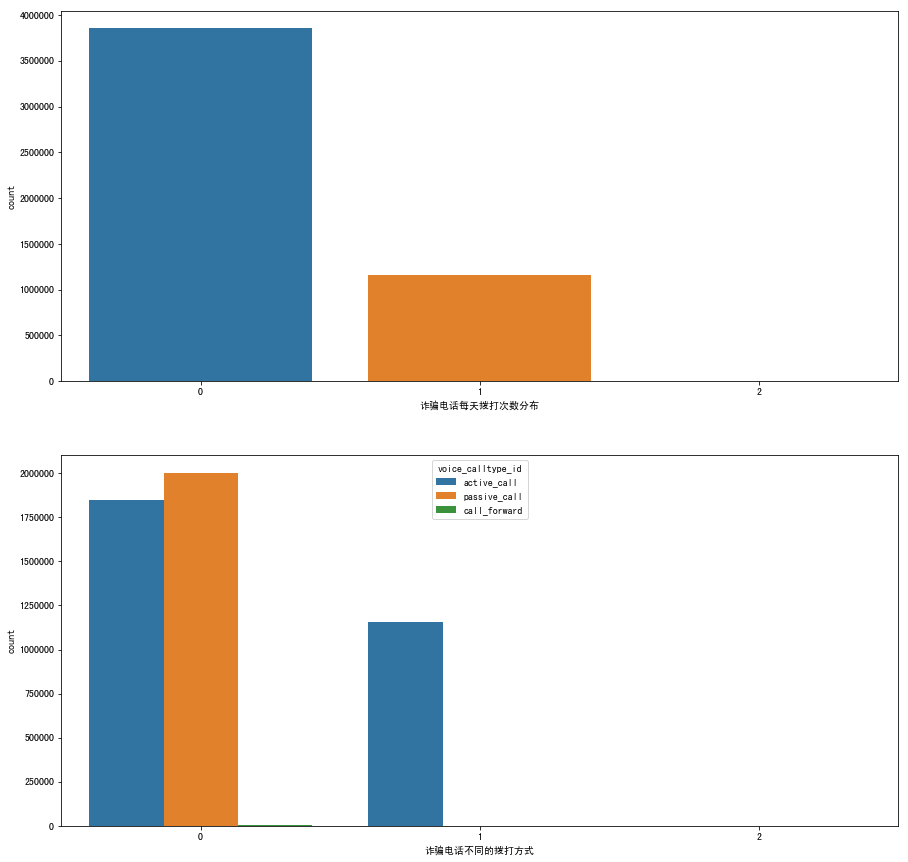

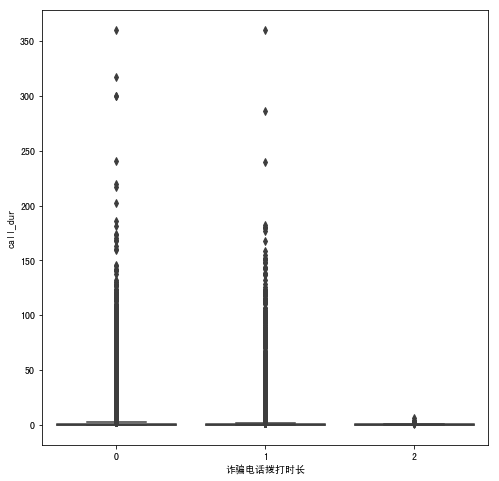

In [20]:

fig,ax = plt.subplots(2,1,figsize=(15,15))

# 诈骗电话与非诈骗电话的数量关系，2.0---->诈骗电话打给诈骗电话
sns.countplot(data=a,x='label',ax=ax[0])
ax[0].set_xlabel('诈骗电话每天拨打次数分布')


# 主动呼叫，被动呼叫还是呼叫转移
sns.countplot(data=a,x='label',hue = 'voice_calltype_id',ax=ax[1])
ax[1].set_xlabel('诈骗电话不同的拨打方式')

# label = 1， 2， 3 各自的拨叫时长。 可以说存在异常，也可以说没有
fig,ax = plt.subplots(1,1,figsize=(8,8))
sns.boxplot(x=a['label'],y=a['call_dur'],ax=ax)
ax.set_xlabel('诈骗电话拨打时长')
plt.show()

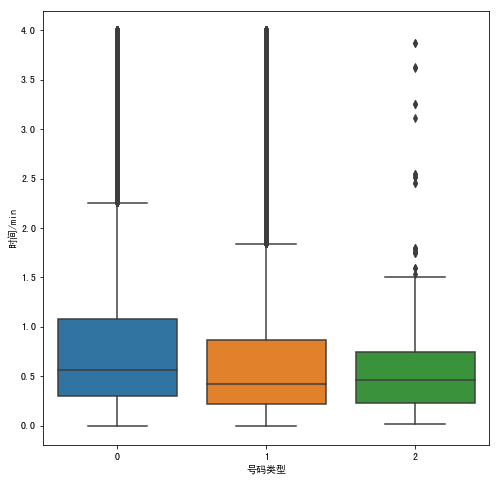

,count,mean,std,min,25%,50%,75%,max,IQR_max_border,percent_large_than_max_border（%）
call_dur,5015430.0,1.351015,3.155451,0.0,0.283333,0.566667,1.216667,359.966667,4.016667,6.096247


In [21]:
# label = 1， 2， 3 各自的拨叫时长。从可视化来看，通话时长不好做甄别。因为几个小时的通话也是存在的
# 尝试用IQR进行清除后观察
b = pd.DataFrame(a.describe()['call_dur']).T
# Q3 + K(Q3 - Q1) = 
b['IQR_max_border'] = b['75%'] + 3 * (b['75%'] - b['25%'])
b['percent_large_than_max_border（%）'] = 100*a[a['call_dur'] > 4.016667].shape[0]/b['count']

# 将超过max_Border的去掉
tmp = a.copy()
tmp = tmp[tmp['call_dur'] < b.loc['call_dur','IQR_max_border']]

fig,ax = plt.subplots(1,1,figsize=(8,8))
sns.boxplot(x=tmp['label'],y=tmp['call_dur'],ax=ax)
ax.set_xlabel('号码类型')
ax.set_ylabel('时间/min')
plt.show()
b

In [22]:
# 拨打电话2min以上的 数目。可以看到相差不大。除了label==2的
c = pd.DataFrame(a[(a['call_dur']>2) & (a['label'] == 0)].describe()['call_dur']).T
c = pd.concat([c,pd.DataFrame(a[(a['call_dur']>2) & (a['label'] == 1)].describe()['call_dur']).T],axis=0)
c = pd.concat([c,pd.DataFrame(a[(a['call_dur']>2) & (a['label'] == 2)].describe()['call_dur']).T],axis=0)
c

,count,mean,std,min,25%,50%,75%,max
call_dur,582588.0,5.809937,6.646894,2.016667,2.566667,3.566667,6.100000,359.900000
call_dur,132836.0,5.774949,7.134650,2.016667,2.550000,3.500000,5.816667,359.966667
call_dur,14.0,3.276190,1.010938,2.450000,2.525000,3.183333,3.629167,6.233333


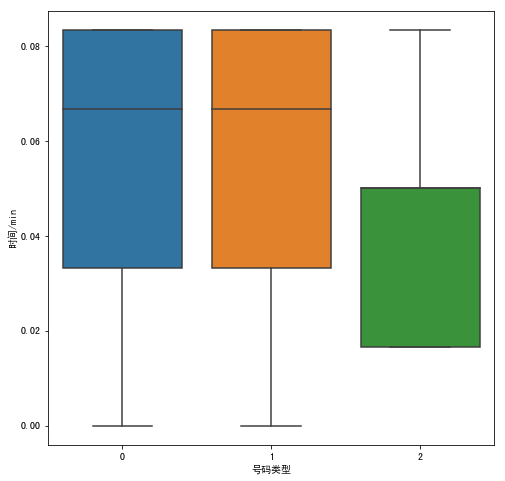

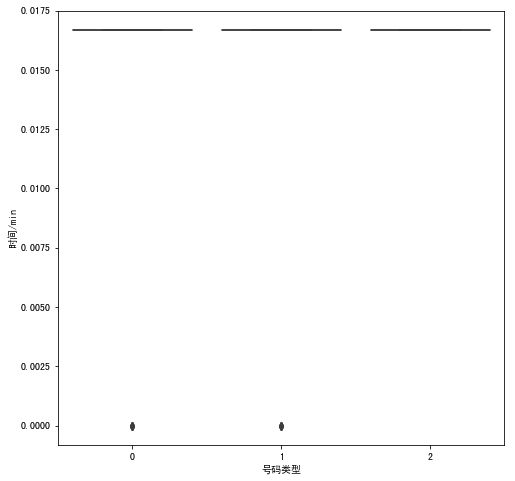

,count,mean,std,min,25%,50%,75%,max
call_dur,27167.0,0.022380,0.007924,0.000000,0.016667,0.016667,0.033333,0.033333
call_dur,12125.0,0.023309,0.008185,0.000000,0.016667,0.016667,0.033333,0.033333
call_dur,3.0,0.016667,0.000000,0.016667,0.016667,0.016667,0.016667,0.016667


In [23]:
# a. 接通就挂掉的，1秒内的，还要观察下0秒的
# 观察2s内的分布情况
tmp = a[a['call_dur'] < 0.084]
fig,ax = plt.subplots(1,1,figsize=(8,8))
sns.boxplot(x=tmp['label'],y=tmp['call_dur'],ax=ax)
ax.set_xlabel('号码类型')
ax.set_ylabel('时间/min')
plt.show()

# 观察2s内的分布情况
tmp = a[a['call_dur'] < 0.017]
fig,ax = plt.subplots(1,1,figsize=(8,8))
sns.boxplot(x=tmp['label'],y=tmp['call_dur'],ax=ax)
ax.set_xlabel('号码类型')
ax.set_ylabel('时间/min')
plt.show()

# 2s内分布
c = pd.DataFrame(a[(a['call_dur']<0.034) & (a['label'] == 0)].describe()['call_dur']).T
c = pd.concat([c,pd.DataFrame(a[(a['call_dur']<0.034) & (a['label'] == 1)].describe()['call_dur']).T],axis=0)
c = pd.concat([c,pd.DataFrame(a[(a['call_dur']<0.034) & (a['label'] == 2)].describe()['call_dur']).T],axis=0)
c

# 0和1的都差不多，只不过1有通话时间为0的，可能是自动的拨打电话，可能作为特征

In [24]:
# 取一小时
a['start_datetime_hour'] = a['start_datetime'].str.replace(r':\d+:\d+$','')
# 取一分钟
a['start_datetime_min'] = a['start_datetime'].str.replace(r':\d+$','')
# 取一天
a['start_datetime_day'] = a['start_datetime'].str.replace(r'\d+:\d+:\d+$','')



具体数据：
                  0              1           2
count  2.230358e+06  269034.000000  182.000000
mean   1.728662e+00       4.310422    1.340659
std    1.620644e+00       6.281007    0.837251
min    1.000000e+00       1.000000    1.000000
25%    1.000000e+00       1.000000    1.000000
50%    1.000000e+00       2.000000    1.000000
75%    2.000000e+00       4.000000    1.000000
max    1.720000e+02      71.000000    6.000000


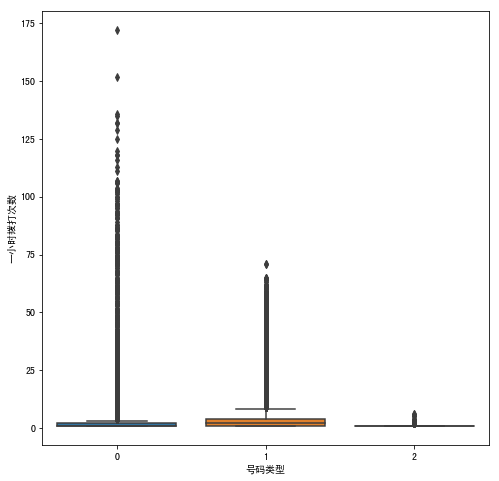

具体数据：
                  0             1           2
count  3.742847e+06  1.104274e+06  236.000000
mean   1.030108e+00  1.050147e+00    1.033898
std    1.812145e-01  2.254890e-01    0.181352
min    1.000000e+00  1.000000e+00    1.000000
25%    1.000000e+00  1.000000e+00    1.000000
50%    1.000000e+00  1.000000e+00    1.000000
75%    1.000000e+00  1.000000e+00    1.000000
max    1.100000e+01  6.000000e+00    2.000000


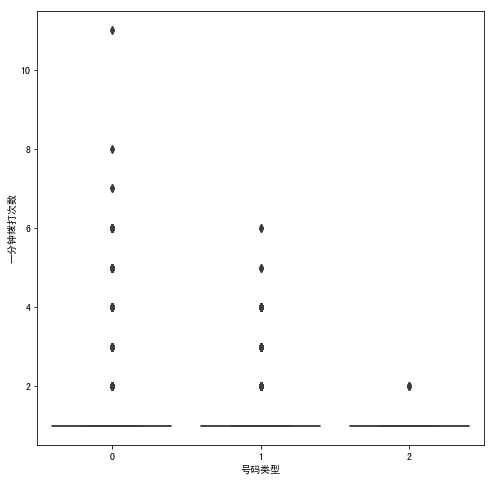

具体数据：
                   0             1           2
count  652710.000000  71163.000000  127.000000
mean        5.906966     16.295687    1.921260
std         8.695102     35.111671    1.515037
min         1.000000      1.000000    1.000000
25%         2.000000      2.000000    1.000000
50%         3.000000      4.000000    1.000000
75%         7.000000     12.000000    2.000000
max      1096.000000    565.000000    9.000000


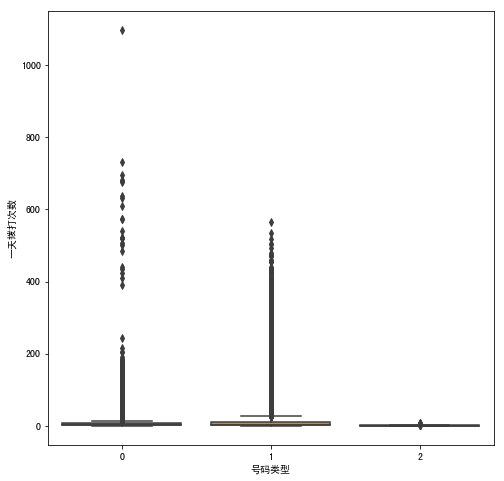

In [26]:
# b. 观察单位时间内的拨打分钟数，比如说一天内的所有诈骗号码的平均拨打次数.电话打的最多的自然是诈骗电话啦

# 一小时内打出多少电话
b = a.groupby(['label','start_datetime_hour','phone_no_m']).count()

zero = pd.DataFrame(b.loc[0]['opposite_no_m'])
zero['label'] = 0
one = pd.DataFrame(b.loc[1]['opposite_no_m'])
one['label'] = 1
two = pd.DataFrame(b.loc[2]['opposite_no_m'])
two['label'] = 2

tmp = pd.concat([zero.describe(),one.describe(),two.describe()],axis=1)
tmp.drop(columns='label',inplace=True)
tmp.columns=['0','1','2']
print('具体数据：')
print(tmp)

tmp = pd.concat([zero,one,two])
tmp.rename(columns={'opposite_no_m':'call_nums'},inplace=True)

fig,ax = plt.subplots(1,1,figsize=(8,8))
sns.boxplot(x=tmp['label'],y=tmp['call_nums'],ax=ax)
ax.set_xlabel('号码类型')
ax.set_ylabel('一小时拨打次数')
plt.show()

# 一分钟内打出多少电话

b = a.groupby(['label','start_datetime_min','phone_no_m']).count()

zero = pd.DataFrame(b.loc[0]['opposite_no_m'])
zero['label'] = 0
one = pd.DataFrame(b.loc[1]['opposite_no_m'])
one['label'] = 1
two = pd.DataFrame(b.loc[2]['opposite_no_m'])
two['label'] = 2

tmp = pd.concat([zero.describe(),one.describe(),two.describe()],axis=1)
tmp.drop(columns='label',inplace=True)
tmp.columns=['0','1','2']
print('具体数据：')
print(tmp)

tmp = pd.concat([zero,one,two])
tmp.rename(columns={'opposite_no_m':'call_nums'},inplace=True)

fig,ax = plt.subplots(1,1,figsize=(8,8))
sns.boxplot(x=tmp['label'],y=tmp['call_nums'],ax=ax)
ax.set_xlabel('号码类型')
ax.set_ylabel('一分钟拨打次数')
plt.show()

# 一天内打出多少电话

b = a.groupby(['label','start_datetime_day','phone_no_m']).count()

zero = pd.DataFrame(b.loc[0]['opposite_no_m'])
zero['label'] = 0
one = pd.DataFrame(b.loc[1]['opposite_no_m'])
one['label'] = 1
two = pd.DataFrame(b.loc[2]['opposite_no_m'])
two['label'] = 2

tmp = pd.concat([zero.describe(),one.describe(),two.describe()],axis=1)
tmp.drop(columns='label',inplace=True)
tmp.columns=['0','1','2']
print('具体数据：')
print(tmp)

tmp = pd.concat([zero,one,two])
tmp.rename(columns={'opposite_no_m':'call_nums'},inplace=True)

fig,ax = plt.subplots(1,1,figsize=(8,8))
sns.boxplot(x=tmp['label'],y=tmp['call_nums'],ax=ax)
ax.set_xlabel('号码类型')
ax.set_ylabel('一天拨打次数')
plt.show()

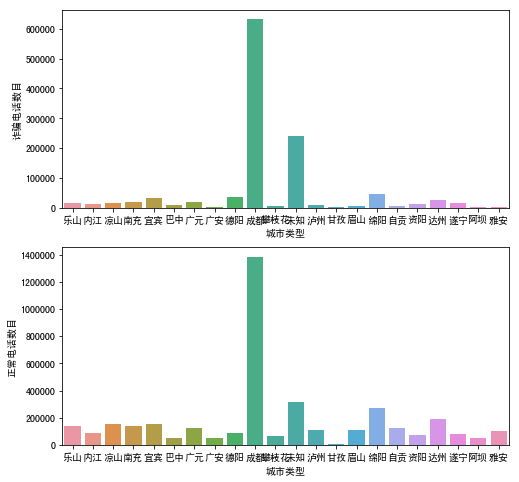

In [27]:
fig,ax = plt.subplots(2,1,figsize=(8,8))
sns.countplot(x = a[a['label'] >= 1]['city_name'],ax=ax[0])
ax[0].set_xlabel('城市类型')
ax[0].set_ylabel('诈骗电话数目')

sns.countplot(x = a[a['label'] == 0]['city_name'],ax=ax[1])
ax[1].set_xlabel('城市类型')
ax[1].set_ylabel('正常电话数目')
plt.show()

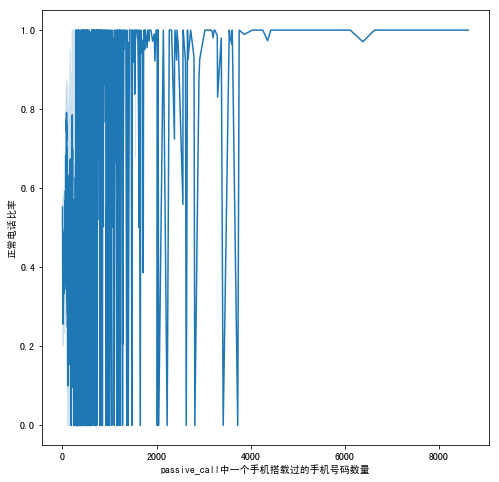

In [137]:
# imei_m 和诈骗电话的关系
# 针对passive_call
b = a[a['voice_calltype_id'] == 'passive_call']
b = a[['opposite_no_m','imei_m','label']].drop_duplicates()

# 将label == 2的化为 1,因为都是诈骗电话,所以没关系
b['label'] = b['label'].apply(lambda x:x/2 if x == 2 else x/1)
b.drop_duplicates(inplace=True)

# 查找一个手机序列号有多少个手机号码
b = pd.concat([b.groupby('imei_m').count(),b.groupby('imei_m').sum()],axis=1)

b.columns = ['total','total_label','normal_label']
b['normal_call_ratio'] = b['normal_label']/b['total_label']
b['fraud_call_ratio'] = (b['total_label'] - b['normal_label'])/b['total_label']
b = b[['total','normal_call_ratio','fraud_call_ratio']]

fig,ax = plt.subplots(1,1,figsize=(8,8))
sns.lineplot(x=b['total'],y=b['normal_call_ratio'],ax=ax)

ax.set_ylabel('正常电话比率')
ax.set_xlabel('passive_call中一个手机搭载过的手机号码数量')
plt.show()


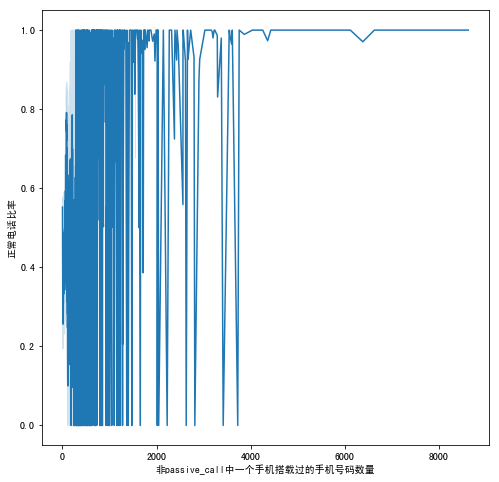

In [138]:
# imei_m 和诈骗电话的关系
# 针对active call 和 call_foward
b = a[a['voice_calltype_id'] != 'passive_call']
b = a[['opposite_no_m','imei_m','label']].drop_duplicates()

# 将label == 2的化为 1,因为都是诈骗电话,所以没关系
b['label'] = b['label'].apply(lambda x:x/2 if x == 2 else x/1)
b.drop_duplicates(inplace=True)

# 查找一个手机序列号有多少个手机号码
b = pd.concat([b.groupby('imei_m').count(),b.groupby('imei_m').sum()],axis=1)

b.columns = ['total','total_label','normal_label']
b['normal_call_ratio'] = b['normal_label']/b['total_label']
b['fraud_call_ratio'] = (b['total_label'] - b['normal_label'])/b['total_label']
b = b[['total','normal_call_ratio','fraud_call_ratio']]

fig,ax = plt.subplots(1,1,figsize=(8,8))
sns.lineplot(x=b['total'],y=b['normal_call_ratio'],ax=ax)

ax.set_ylabel('正常电话比率')
ax.set_xlabel('非passive_call中一个手机搭载过的手机号码数量')
plt.show()


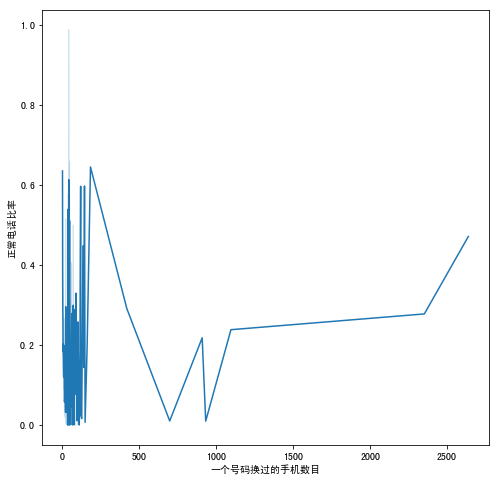

In [139]:
b = a[a['voice_calltype_id'] == 'passive_call']
b = a[['opposite_no_m','imei_m','label']].drop_duplicates()

# 将label == 2的化为 1,因为都是诈骗电话,所以没关系
b['label'] = b['label'].apply(lambda x:x/2 if x == 2 else x/1)
b.drop_duplicates(inplace=True)



b = pd.concat([b.groupby('opposite_no_m').count(),b.groupby('opposite_no_m').sum()],axis=1)

b.columns = ['total','total_label','normal_label']
b['normal_call_ratio'] = b['normal_label']/b['total_label']
b['fraud_call_ratio'] = (b['total_label'] - b['normal_label'])/b['total_label']
b = b[['total','normal_call_ratio','fraud_call_ratio']]

fig,ax = plt.subplots(1,1,figsize=(8,8))
sns.lineplot(x=b['total'],y=b['normal_call_ratio'],ax=ax)

ax.set_ylabel('正常电话比率')
ax.set_xlabel('一个号码换过的手机数目')
plt.show()

In [ ]:
留一个聚类分析，可能需要

In [6]:
train_voc.to_pickle('after_EDA/train_voc.pkl')
test_voc.to_pickle('after_EDA/test_voc.pkl')

In [30]:
del b,c,tmp,one,two,zero
gc.collect()

43